<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/BoneAgePredictor_limit128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import skimage.transform

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [6]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [7]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4609, 68)
        self.fc2 = nn.Linear(69, 1)
        #self.fc2 = nn.Linear(64, 1)
    
        

    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,4608)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

In [9]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [11]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=32, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=32, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=32, shuffle=True, **kwargs)

In [13]:
device

device(type='cpu')

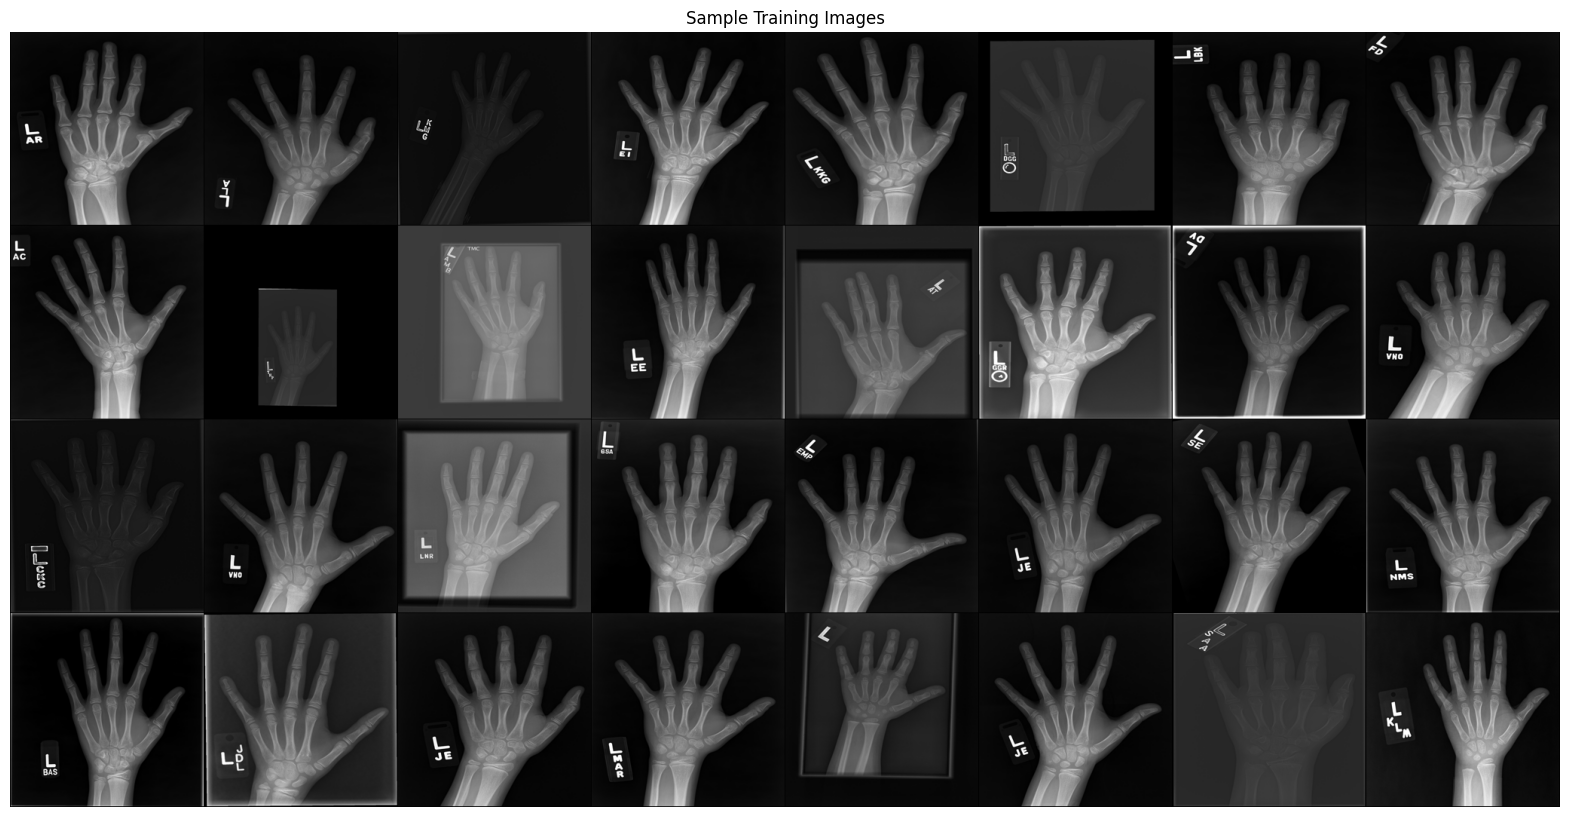

In [14]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [15]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [16]:
train_losses = []
val_losses = []
for epoch in range(20):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model1_280323.pth')

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
Train Epoch: 4 [4864/10089 (48%)]	Loss: 0.366196
Train Epoch: 4 [4896/10089 (48%)]	Loss: 0.560032
Train Epoch: 4 [4928/10089 (49%)]	Loss: 0.412090
Train Epoch: 4 [4960/10089 (49%)]	Loss: 0.339933
Train Epoch: 4 [4992/10089 (49%)]	Loss: 0.440004
Train Epoch: 4 [5024/10089 (50%)]	Loss: 0.387045
Train Epoch: 4 [5056/10089 (50%)]	Loss: 0.382616
Train Epoch: 4 [5088/10089 (50%)]	Loss: 0.509647
Train Epoch: 4 [5120/10089 (51%)]	Loss: 0.433517
Train Epoch: 4 [5152/10089 (51%)]	Loss: 0.342233
Train Epoch: 4 [5184/10089 (51%)]	Loss: 0.334485
Train Epoch: 4 [5216/10089 (52%)]	Loss: 0.409196
Train Epoch: 4 [5248/10089 (52%)]	Loss: 0.329411
Train Epoch: 4 [5280/10089 (52%)]	Loss: 0.427786
Train Epoch: 4 [5312/10089 (53%)]	Loss: 0.362929
Train Epoch: 4 [5344/10089 (53%)]	Loss: 0.458459
Train Epoch: 4 [5376/10089 (53%)]	Loss: 0.394820
Train Epoch: 4 [5408/10089 (53%)]	Loss: 0.333763
Train Epoch: 4 [5440/10089 (54%)]	Loss: 0.495116
Train Epoch:

In [17]:
checkpoint = torch.load('model1_280323.pth')
checkpoint

{'epoch': 20,
 'train_loss': [0.6052833514731051,
  0.4785416024284976,
  0.44089736450655015,
  0.38031652537760297,
  0.43656080229318545,
  0.33050462551005905,
  0.30223744196722113,
  0.3233447621439076,
  0.27860508706858994,
  0.2491920047821572,
  0.2515308616679742,
  0.2809314203076799,
  0.2171947833552343,
  0.2474677881072207,
  0.213382609116431,
  0.19628024617203604,
  0.18284632519966967,
  0.17523947951365776,
  0.1751945819906298,
  0.20328369999828785],
 'val_loss': [0.5677682335586683,
  0.4097762928806699,
  0.40234958901790113,
  0.34304641674191116,
  0.4294173124124229,
  0.3379534501667163,
  0.31401263843697313,
  0.3466973279672595,
  0.335657250742228,
  0.3086798977942081,
  0.3186187486180454,
  0.3470918602815871,
  0.2986816318193523,
  0.3335080293693179,
  0.2955066985936422,
  0.3033773227169067,
  0.29939172967635524,
  0.29336975428474,
  0.29492944997649106,
  0.321477881163881],
 'state_dict': OrderedDict([('conv1.weight',
               tensor([

In [18]:
model.load_state_dict(checkpoint['state_dict'])
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [19]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [20]:
epoch = checkpoint['epoch']
epoch

20

In [21]:
train_loss = checkpoint['train_loss']
train_loss

[0.6052833514731051,
 0.4785416024284976,
 0.44089736450655015,
 0.38031652537760297,
 0.43656080229318545,
 0.33050462551005905,
 0.30223744196722113,
 0.3233447621439076,
 0.27860508706858994,
 0.2491920047821572,
 0.2515308616679742,
 0.2809314203076799,
 0.2171947833552343,
 0.2474677881072207,
 0.213382609116431,
 0.19628024617203604,
 0.18284632519966967,
 0.17523947951365776,
 0.1751945819906298,
 0.20328369999828785]

In [22]:
val_loss = checkpoint['val_loss']
val_loss

[0.5677682335586683,
 0.4097762928806699,
 0.40234958901790113,
 0.34304641674191116,
 0.4294173124124229,
 0.3379534501667163,
 0.31401263843697313,
 0.3466973279672595,
 0.335657250742228,
 0.3086798977942081,
 0.3186187486180454,
 0.3470918602815871,
 0.2986816318193523,
 0.3335080293693179,
 0.2955066985936422,
 0.3033773227169067,
 0.29939172967635524,
 0.29336975428474,
 0.29492944997649106,
 0.321477881163881]

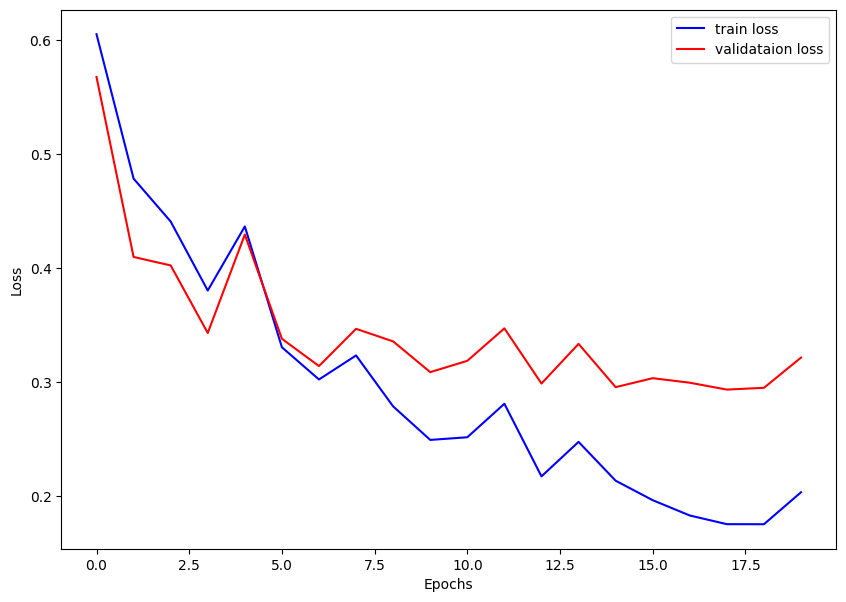

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [25]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)

#**GradCam**

In [26]:
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = model
model.load_state_dict(checkpoint['state_dict'])

# Set the model to evaluation mode
model.eval()

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [27]:
layer = model.conv5  # replace with your model's last convolutional layer
layer

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))

##***image 1***

In [62]:
input = transform(Image.open(dataset_path('boneage_training_dataset/1377.png')).resize((256,256))).double()  # replace with your input
input

tensor([[[0.9451, 0.9412, 0.7765,  ..., 0.2745, 0.2784, 0.2824],
         [0.9451, 0.9451, 0.7843,  ..., 0.2706, 0.2706, 0.2784],
         [0.9451, 0.9451, 0.7882,  ..., 0.2667, 0.2706, 0.2745],
         ...,
         [0.8784, 0.8824, 0.8745,  ..., 0.1765, 0.1804, 0.1804],
         [0.8824, 0.8824, 0.8863,  ..., 0.1843, 0.1843, 0.1843],
         [0.8863, 0.8745, 0.8824,  ..., 0.1922, 0.1882, 0.1882]]],
       dtype=torch.float64)

In [63]:
np.shape(input)

torch.Size([1, 256, 256])

In [64]:
#input = input[None,:,:,:]
np.shape(input)

torch.Size([1, 256, 256])

In [65]:
m = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m

tensor([1.], dtype=torch.float64)

In [66]:
input = input.resize(1,1,256,256)
input

tensor([[[[0.9451, 0.9412, 0.7765,  ..., 0.2745, 0.2784, 0.2824],
          [0.9451, 0.9451, 0.7843,  ..., 0.2706, 0.2706, 0.2784],
          [0.9451, 0.9451, 0.7882,  ..., 0.2667, 0.2706, 0.2745],
          ...,
          [0.8784, 0.8824, 0.8745,  ..., 0.1765, 0.1804, 0.1804],
          [0.8824, 0.8824, 0.8863,  ..., 0.1843, 0.1843, 0.1843],
          [0.8863, 0.8745, 0.8824,  ..., 0.1922, 0.1882, 0.1882]]]],
       dtype=torch.float64)

In [67]:
m = m.resize(1,1)
m

tensor([[1.]], dtype=torch.float64)

In [68]:
output = model(input, m)
output

tensor([[0.8843]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [69]:
features = []
def get_features_hook(model, input, output):
    features.append(output)

hook_handle = model.conv5.register_forward_hook(get_features_hook)
output1 = model(input,m)
hook_handle.remove()

feature_maps = features[0]
gradients = model.conv5.weight.grad

In [70]:
weights = torch.mean(gradients, axis=(2, 3))
cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights[0]):
    cam += w * feature_maps[0, i, :, :]
cam = torch.nn.functional.relu(cam)
cam = cam.detach().numpy()

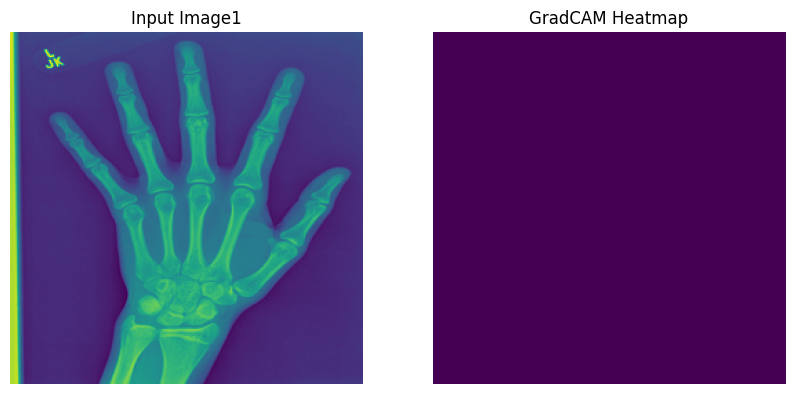

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image1')
ax[1].imshow(cam)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

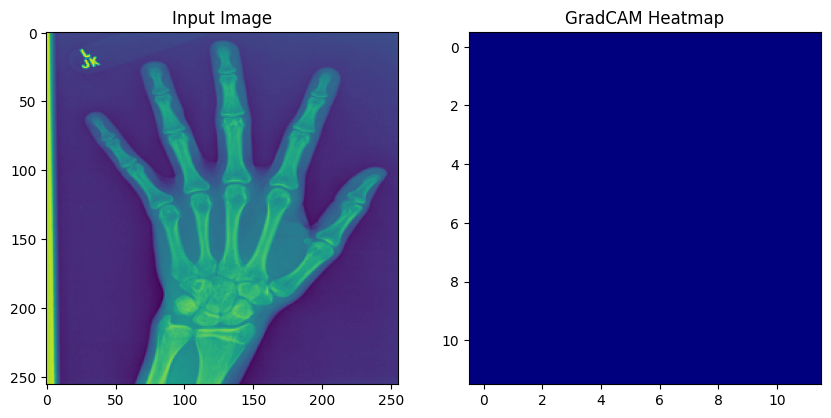

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image')
ax[1].imshow(cam, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

In [73]:
input.shape

torch.Size([1, 1, 256, 256])

In [74]:
cam.shape

(12, 12)

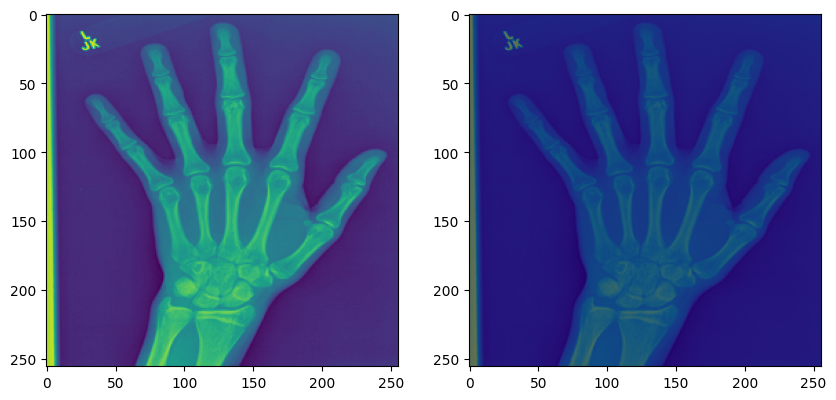

In [75]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

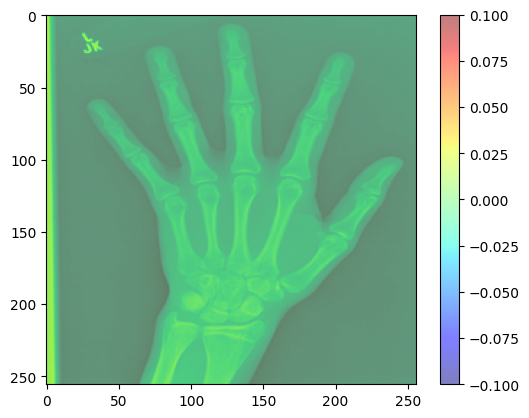

In [76]:
plt.imshow(input.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()


##***image 2***

In [77]:
input = transform(Image.open(dataset_path('boneage_training_dataset/13305.png')).resize((256,256))).double()  # replace with your input
input

tensor([[[0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
         [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
         [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0235],
         ...,
         [0.1294, 0.1255, 0.1255,  ..., 0.1059, 0.1059, 0.1059],
         [0.2196, 0.2157, 0.2196,  ..., 0.2157, 0.2157, 0.2196],
         [0.3961, 0.3922, 0.3922,  ..., 0.4196, 0.4235, 0.4196]]],
       dtype=torch.float64)

In [78]:
np.shape(input)

torch.Size([1, 256, 256])

In [79]:
#input = input[None,:,:,:]
np.shape(input)

torch.Size([1, 256, 256])

In [80]:
m = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m

tensor([1.], dtype=torch.float64)

In [83]:
input = input.resize(1,1,256,256)
input

tensor([[[[0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
          [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0196],
          [0.0627, 0.0627, 0.0627,  ..., 0.0196, 0.0196, 0.0235],
          ...,
          [0.1294, 0.1255, 0.1255,  ..., 0.1059, 0.1059, 0.1059],
          [0.2196, 0.2157, 0.2196,  ..., 0.2157, 0.2157, 0.2196],
          [0.3961, 0.3922, 0.3922,  ..., 0.4196, 0.4235, 0.4196]]]],
       dtype=torch.float64)

In [84]:
m = m.resize(1,1)
m

tensor([[1.]], dtype=torch.float64)

In [85]:
output = model(input, m)
output

tensor([[2.2277]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [86]:
features = []
def get_features_hook(model, input, output):
    features.append(output)

hook_handle = model.conv5.register_forward_hook(get_features_hook)
output = model(input,m)
hook_handle.remove()

feature_maps = features[0]
gradients = model.conv5.weight.grad

In [87]:
weights = torch.mean(gradients, axis=(2, 3))
cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights[0]):
    cam += w * feature_maps[0, i, :, :]
cam = torch.nn.functional.relu(cam)
cam = cam.detach().numpy()

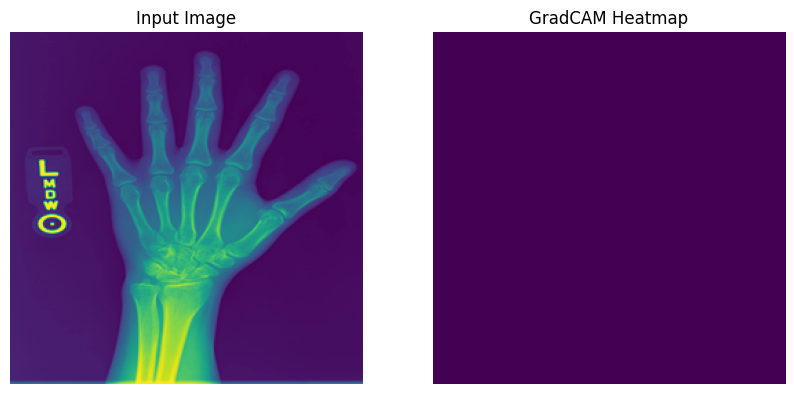

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image')
ax[1].imshow(cam)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

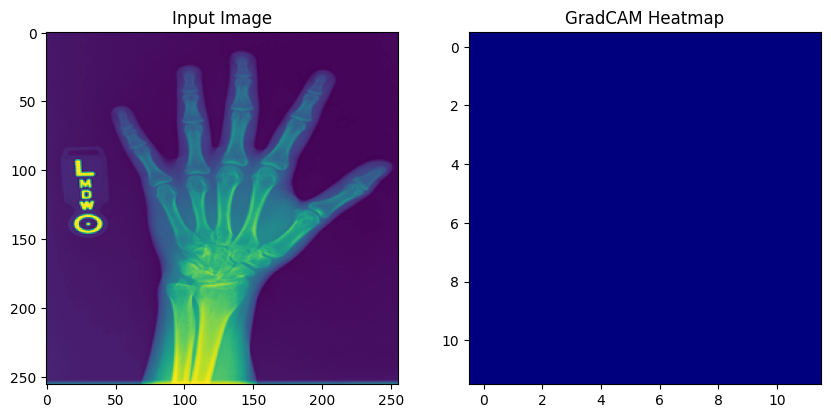

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image')
ax[1].imshow(cam, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

In [90]:
input.shape

torch.Size([1, 1, 256, 256])

In [91]:
cam.shape

(12, 12)

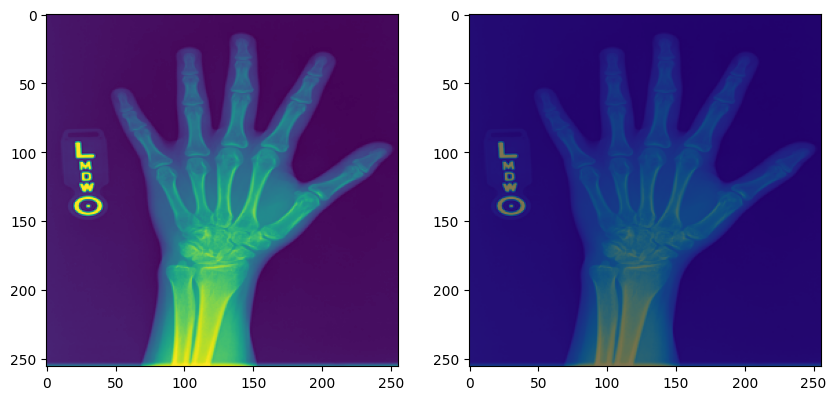

In [92]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

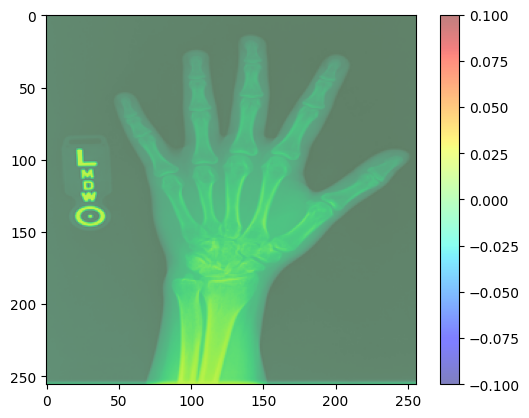

In [93]:
plt.imshow(input.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

##***image 3***

In [94]:
input = transform(Image.open(dataset_path('boneage_training_dataset/12930.png')).resize((256,256))).double()  # replace with your input
input

tensor([[[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0471, 0.0510],
         [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
         [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
         ...,
         [0.0824, 0.0824, 0.0784,  ..., 0.0941, 0.0902, 0.0941],
         [0.0784, 0.0784, 0.0784,  ..., 0.0863, 0.0863, 0.0863],
         [0.1333, 0.1333, 0.1333,  ..., 0.0980, 0.0980, 0.0980]]],
       dtype=torch.float64)

In [95]:
np.shape(input)

torch.Size([1, 256, 256])

In [96]:
#input = input[None,:,:,:]
np.shape(input)

torch.Size([1, 256, 256])

In [97]:
m = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m

tensor([1.], dtype=torch.float64)

In [98]:
input = input.resize(1,1,256,256)
input

tensor([[[[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0471, 0.0510],
          [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
          [0.0510, 0.0510, 0.0510,  ..., 0.0471, 0.0471, 0.0471],
          ...,
          [0.0824, 0.0824, 0.0784,  ..., 0.0941, 0.0902, 0.0941],
          [0.0784, 0.0784, 0.0784,  ..., 0.0863, 0.0863, 0.0863],
          [0.1333, 0.1333, 0.1333,  ..., 0.0980, 0.0980, 0.0980]]]],
       dtype=torch.float64)

In [99]:
m = m.resize(1,1)
m

tensor([[1.]], dtype=torch.float64)

In [100]:
output = model(input, m)
output

tensor([[0.0335]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [101]:
features = []
def get_features_hook(model, input, output):
    features.append(output)

hook_handle = model.conv5.register_forward_hook(get_features_hook)
output = model(input,m)
hook_handle.remove()

feature_maps = features[0]
gradients = model.conv5.weight.grad

In [102]:
weights = torch.mean(gradients, axis=(2, 3))
cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights[0]):
    cam += w * feature_maps[0, i, :, :]
cam = torch.nn.functional.relu(cam)
cam = cam.detach().numpy()

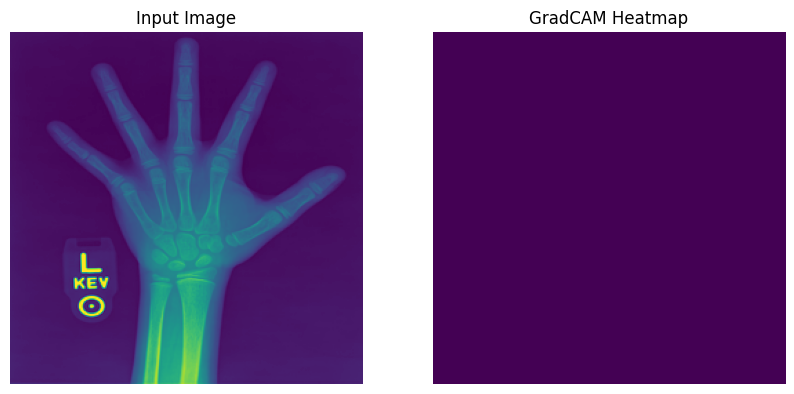

In [103]:
ig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image')
ax[1].imshow(cam)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

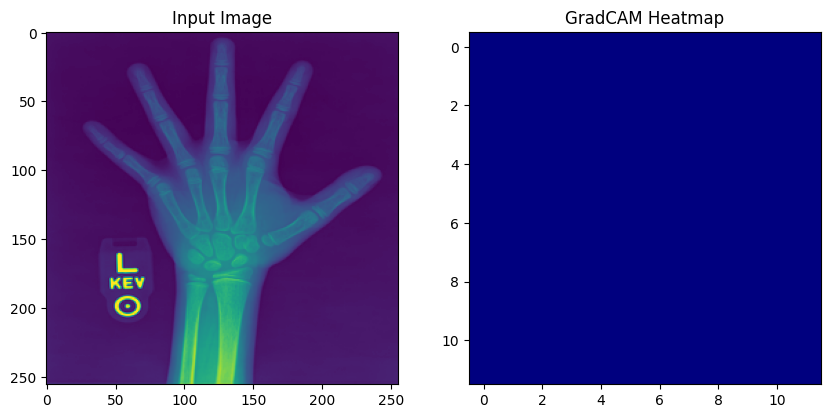

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image')
ax[1].imshow(cam, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

In [105]:
input.shape

torch.Size([1, 1, 256, 256])

In [106]:
cam.shape

(12, 12)

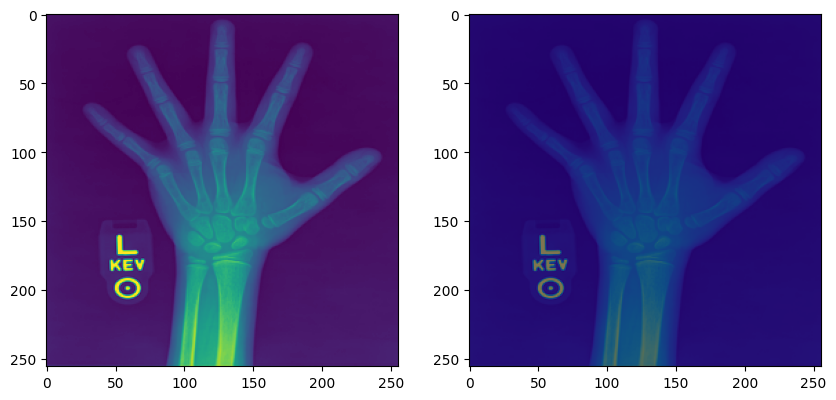

In [107]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

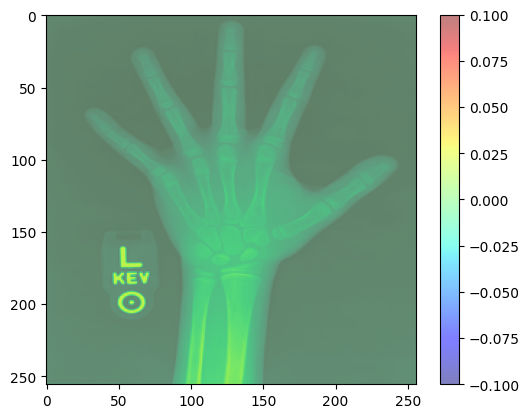

In [108]:
plt.imshow(input.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

##***image 4***

In [109]:
input = transform(Image.open(dataset_path('boneage_training_dataset/12496.png')).resize((256,256))).double()  # replace with your input
input

tensor([[[0.2902, 0.2078, 0.2118,  ..., 0.4314, 0.4667, 0.5294],
         [0.2039, 0.1294, 0.1333,  ..., 0.1804, 0.2235, 0.2980],
         [0.2000, 0.1216, 0.1255,  ..., 0.0902, 0.1451, 0.2392],
         ...,
         [0.2118, 0.2039, 0.2039,  ..., 0.2000, 0.3098, 0.4627],
         [0.4118, 0.4039, 0.3961,  ..., 0.2000, 0.3098, 0.4627],
         [0.7333, 0.7216, 0.7137,  ..., 0.2353, 0.3294, 0.4706]]],
       dtype=torch.float64)

In [110]:
np.shape(input)

torch.Size([1, 256, 256])

In [111]:
#input = input[None,:,:,:]
np.shape(input)

torch.Size([1, 256, 256])

In [112]:
m = torch.from_numpy(np.array([1.0])).double() # given that it's a picture of "male"
m

tensor([1.], dtype=torch.float64)

In [113]:
input = input.resize(1,1,256,256)
input

tensor([[[[0.2902, 0.2078, 0.2118,  ..., 0.4314, 0.4667, 0.5294],
          [0.2039, 0.1294, 0.1333,  ..., 0.1804, 0.2235, 0.2980],
          [0.2000, 0.1216, 0.1255,  ..., 0.0902, 0.1451, 0.2392],
          ...,
          [0.2118, 0.2039, 0.2039,  ..., 0.2000, 0.3098, 0.4627],
          [0.4118, 0.4039, 0.3961,  ..., 0.2000, 0.3098, 0.4627],
          [0.7333, 0.7216, 0.7137,  ..., 0.2353, 0.3294, 0.4706]]]],
       dtype=torch.float64)

In [114]:
m = m.resize(1,1)
m

/usr/local/lib/python3.9/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor([[1.]], dtype=torch.float64)

In [115]:
output = model(input, m)
output

tensor([[-0.3849]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [116]:
features = []
def get_features_hook(model, input, output):
    features.append(output)

hook_handle = model.conv5.register_forward_hook(get_features_hook)
output = model(input,m)
hook_handle.remove()

feature_maps = features[0]
gradients = model.conv5.weight.grad

In [117]:
weights = torch.mean(gradients, axis=(2, 3))
cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32)
for i, w in enumerate(weights[0]):
    cam += w * feature_maps[0, i, :, :]
cam = torch.nn.functional.relu(cam)
cam = cam.detach().numpy()

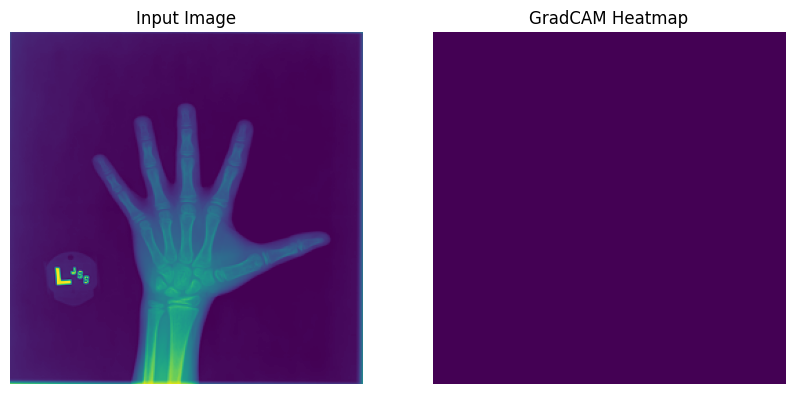

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
ax[0].axis('off')
ax[0].set_title('Input Image')
ax[1].imshow(cam)#, cmap='jet')
ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

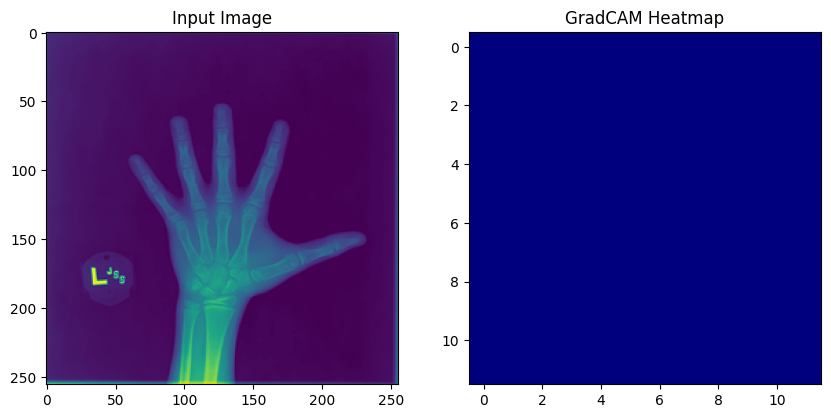

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].axis('off')
ax[0].set_title('Input Image')
ax[1].imshow(cam, cmap='jet')
#ax[1].axis('off')
ax[1].set_title('GradCAM Heatmap')
plt.show()

In [120]:
input.shape

torch.Size([1, 1, 256, 256])

In [121]:
cam.shape

(12, 12)

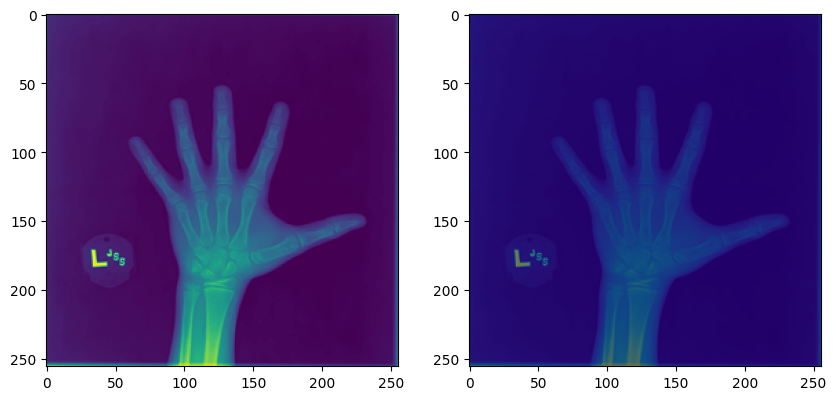

In [122]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(input.squeeze().detach().numpy())
#ax[0].set_title("Video: " + sample_video + "Actual: " + y )

ax[1].imshow(input.squeeze().detach().numpy())
ax[1].imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')

#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()

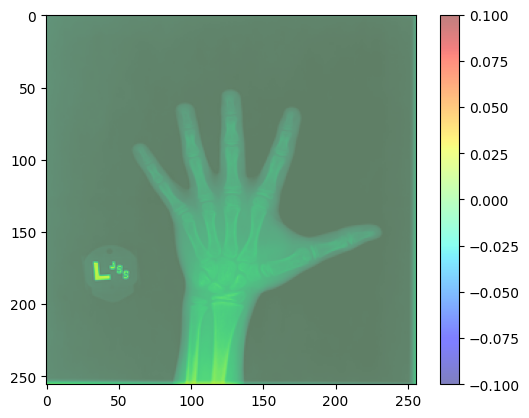

In [123]:
plt.imshow(input.squeeze().detach().numpy())
plt.imshow(skimage.transform.resize(cam, (input.shape[2],input.shape[3] )), alpha=0.5, cmap='jet')
plt.colorbar()
#plt.imshow(cam.detach().numpy(), alpha=0.5,cmap='jet')
#y_pred = str(y_pred.cpu().data.numpy())
#ax[1].set_title(y_pred)
#fig.tight_layout()